# Logistic modeling of the spread of COVID-19

In [1]:
# Import packages
import pandas as pd
import datetime as dt

import numpy as np
from scipy import optimize

from matplotlib import pyplot as plt

from tqdm import tqdm

## Preprocessing

In [2]:
# Load data
# Data retrieved from https://github.com/CSSEGISandData/COVID-19
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Delete province and location
cases = cases.drop(columns=['Province/State', 'Lat', 'Long'])
deaths = deaths.drop(columns=['Province/State', 'Lat', 'Long'])

# Group by country
cases = cases.groupby('Country/Region').sum()
deaths = deaths.groupby('Country/Region').sum()


#process date
#time series is for all countries the same, therefore we just choose Germany
date = [dt.datetime.strptime(ind, '%m/%d/%y').date() for ind in cases.loc["Germany"].index]
date_int = np.array([(d - date[0]).days for d in date])

## Regression

In [3]:
def logistic_fit(t, a, b, c):#w, t, y):
    return a / (1 + np.exp(-b * (t - c)))# - y


def logistic(w, t):
    return w[0] / (1 + np.exp(-w[1] * (t - w[2])))


#finds a start index which has a reasonable large value
def find_start(x):
    m = np.max(x)
    for i in range(len(x)):
        if x[i] > 0.005 * m:
            return i
    return 0


def analyze_country(cases, deaths, country, results, date, date_int, 
                    plot=False, save=True, weighting=True):
    #extract data of country
    cases_np = np.array(cases.loc[country])
    deaths_np = np.array(deaths.loc[country])
    
    #fit both deaths and cases
    #s_i is the start index of the fitting
    #we reduce therefore the weight of the flat curve and consider more
    #recently added values
    #sometimes fitting fails
    try:
        if weighting:
            s_i = find_start(cases_np)
            #weight array
            sigma = np.log10(np.maximum(np.ones(cases_np[s_i:].shape), cases_np[s_i:]))
            popt_c, _ = optimize.curve_fit(logistic_fit, date_int[s_i:], cases_np[s_i:],
                                           sigma=sigma, absolute_sigma=True, 
                                           p0=[100000, 0.1, 60],  maxfev=1000)
            
            
            s_i = find_start(deaths_np)
            #weight array
            sigma = np.log10(np.maximum(np.ones(deaths_np[s_i:].shape), deaths_np[s_i:]))
            popt_d, _ = optimize.curve_fit(logistic_fit, date_int[s_i:], deaths_np[s_i:],
                                           sigma=sigma, absolute_sigma=True,  
                                           p0=[50000, 0.1, 60], maxfev=1000)
        else:
            s_i = find_start(cases_np)
            popt_c, _ = optimize.curve_fit(logistic_fit, date_int[s_i:], cases_np[s_i:],
                                           p0=[100000, 0.1, 60], maxfev=1000)
            
            s_i = find_start(deaths_np)
            popt_d, _ = optimize.curve_fit(logistic_fit, date_int[s_i:], deaths_np[s_i:],
                                           p0=[50000, 0.1, 60], maxfev=1000)

    except (RuntimeError, TypeError):
        return results
    
    #extract paramters
    par0_c = popt_c[0]
    par1_c = popt_c[1]
    par2_c = popt_c[2]
    
    par0_d = popt_d[0]
    par1_d = popt_d[1]
    par2_d = popt_d[2]      
        
    
    #extract meaningful quantities
    current_cases = cases_np[-1].astype(np.int)
    current_deaths = deaths_np[-1].astype(np.int)
    total_cases = np.round(np.max([cases_np[-1], par0_c])).astype(np.int)
    inflection_point_cases = (date[0] + dt.timedelta(days=par2_c)).strftime('%m/%d/%y')
    inflection_point_deaths = (date[0] + dt.timedelta(days=par2_d)).strftime('%m/%d/%y')
    max_new_cases_per_day = np.min([np.round(par0_c * par1_c / 4), 
                                             total_cases]
                                  ).astype(np.int)
    
    total_deaths = np.round(np.max([deaths_np[-1], 
                                    np.min([np.abs(par0_d), 
                                            total_cases])])
                           ).astype(np.int)
    
    r = np.abs(np.round(total_deaths / total_cases * 100, 2))
    death_ratio = r if r > 1e-4 else 0
    
    
    
    #save to results table only if save == True
    if save:
        results['Current cases'].loc[country] = current_cases
        results['Current deaths'].loc[country] = current_deaths
        results['Total cases'].loc[country] = total_cases
        results['Inflection point cases'].loc[country] = inflection_point_cases
        results['Inflection point deaths'].loc[country] = inflection_point_deaths
        results['Max new cases per day'].loc[country] = max_new_cases_per_day
        results['Total deaths'].loc[country] = total_deaths
        results['Death ratio (%)'].loc[country] = death_ratio
    
    
    #save png only if plot == True
    if plot:
        plt.figure(figsize=(15, 10))
        plt.plot(date, cases_np, '.', markersize=12, zorder=2, label='Data')
        plt.plot(date, logistic_fit(date_int, par0_c, par1_c, par2_c), 'r', linewidth=2.0, zorder=1, label='Fit')
        plt.legend(loc=2, fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Confirmed cases in ' + country, fontsize=20)    
        x_infl = (dt.datetime.strptime(inflection_point_cases,
                                      '%m/%d/%y').date())
        plt.axvline(x=x_infl, color="green")
        plt.savefig('plots/cases_' + country.lower() + '.png', dpi=200)
        plt.close()
        
        plt.figure(figsize=(15, 10))
        plt.plot(date, deaths_np, '.', markersize=12, zorder=2, label='Data')
        plt.plot(date, logistic_fit(date_int, par0_d, par1_d, par2_d), 'r', linewidth=2.0, zorder=1, label='Fit')
        plt.legend(loc=2, fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Deaths in ' + country, fontsize=20)
        x_infl = (dt.datetime.strptime(inflection_point_deaths,
                                       '%m/%d/%y').date())
        plt.axvline(x=x_infl, color="green")
        plt.savefig('plots/deaths_' + country.lower() + '.png', dpi=200)
        plt.close()
        
    return results



def calculate_inflection_point(cases, deaths, country, date, date_int, start_day, weighting=True):
    inf_points_c = []
    inf_points_d = []

    for i in range(start_day, len(date)):
        date_np = np.array(date)[:i]
        date_int_np = np.array(date_int)[:i]
        
        #extract data of country
        cases_np = np.array(cases.loc[country])[:i]
        deaths_np = np.array(deaths.loc[country])[:i]
        
        #fit both deaths and cases
        #s_i is the start index of the fitting
        #we reduce therefore the weight of the flat curve and consider more
        #recently added values
        #sometimes fitting fails
        try:
            if weighting:
                s_i = find_start(cases_np)
                #weight array
                sigma = np.log10(np.maximum(np.ones(cases_np[s_i:].shape), cases_np[s_i:]))
                popt_c, _ = optimize.curve_fit(logistic_fit, date_int_np[s_i:], cases_np[s_i:],
                                               sigma=sigma, absolute_sigma=True, 
                                               p0=[100000, 0.1, 60],  maxfev=1000)

                s_i = find_start(deaths_np)
                #weight array
                sigma = np.log10(np.maximum(np.ones(deaths_np[s_i:].shape), deaths_np[s_i:]))
                popt_d, _ = optimize.curve_fit(logistic_fit, date_int_np[s_i:], deaths_np[s_i:],
                                               sigma=sigma, absolute_sigma=True,  
                                               p0=[50000, 0.1, 60], maxfev=1000)
            else:
                s_i = find_start(cases_np)
                popt_c, _ = optimize.curve_fit(logistic_fit, date_int_np[s_i:], cases_np[s_i:],
                                               p0=[100000, 0.1, 60], maxfev=1000)

                s_i = find_start(deaths_np)
                popt_d, _ = optimize.curve_fit(logistic_fit, date_int_np[s_i:], deaths_np[s_i:],
                                               p0=[50000, 0.1, 60], maxfev=1000)

        except (RuntimeError, TypeError):
            continue

        
        
        inflection_point_cases = dt.timedelta(days=popt_c[2])
        inflection_point_deaths = dt.timedelta(days=popt_d[2])        
        inf_points_c.append(inflection_point_cases.days)
        inf_points_d.append(inflection_point_deaths.days)

    return inf_points_c, inf_points_d

In [13]:
#empty results table
results = pd.DataFrame(columns=['Current cases', 'Total cases', 'Inflection point cases', 'Max new cases per day',
                                'Current deaths', 'Total deaths', "Inflection point deaths", 'Death ratio (%)'], 
                       index=cases.index)

#country with plots
countries_to_plot = ['Germany', 'US', 'United Kingdom', 'Brazil', "France"]


for country in tqdm(cases.index):
    plot = country in countries_to_plot
    results = analyze_country(cases, deaths, country, results, date, date_int, plot=plot, weighting=True)

100%|██████████| 181/181 [00:04<00:00, 44.57it/s]


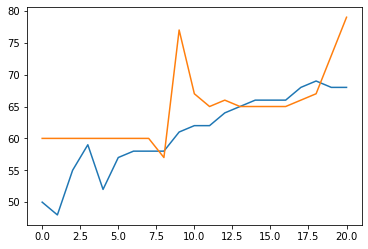

In [15]:
#Experimental feature

#it shows how the inflection point changed over time
#if the curve is constant this would indicate that our fit is ok

inf_points_c, inf_points_d = calculate_inflection_point(cases, deaths, "France", date, date_int, 50)
plt.plot(inf_points_c)
plt.plot(inf_points_d)

## Save results

In [14]:
results_sorted = results.sort_values(by='Current cases', ascending=False)
results_sorted.to_csv(r'logistic-results.csv')